In [43]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)
from IPython.display import display

In [44]:
import os
from pathlib import Path
dirpath = './uHoo/'
paths = sorted(Path(dirpath).glob("*.xlsx"), key=os.path.basename)
raw_udf = pd.concat([pd.read_excel(f, header=None) for f in paths])
raw_udf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Date/time,Instance,Sensor,Value,Units,Temperature,Humidity,PM2.5,CO2,CO,TVOC,NO2,Ozone,Pressure
1,"February 15, 2020 at 04:19PM",Walnut,Air Pressure,1010.97,mbar,21.4,33.9,7.9,807,0,53,21.9,7.9,1011
2,"February 15, 2020 at 04:20PM",Walnut,Air Pressure,1011,mbar,21.4,33.9,7.9,808,0,55,22.1,7.9,1011
3,"February 15, 2020 at 04:23PM",Walnut,Air Pressure,1011.07,mbar,21.4,33.8,7.3,808,0,55,21.1,7.8,1011.1
4,"February 15, 2020 at 04:24PM",Walnut,Air Pressure,1011.1,mbar,21.4,33.9,7.6,812,0,55,22.4,7.9,1011.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,"March 1, 2022 at 05:08AM",Walnut,Air Pressure,1009.21,mbar,17.9,33.1,5,457,0,20,53.1,9.7,1009.2
1600,"March 1, 2022 at 05:09AM",Walnut,Air Pressure,1009.15,mbar,17.9,32.3,5,461,0,20,52.3,9.6,1009.1
1601,"March 1, 2022 at 06:06AM",Walnut,Air Pressure,1008.82,mbar,17.9,30.5,8,463,0,41,58.5,9.8,1008.8
1602,"March 1, 2022 at 06:07AM",Walnut,Air Pressure,1008.85,mbar,17.8,31.5,5,462,0,41,55.6,9.7,1008.9


In [45]:
udf = raw_udf.copy()

# turn first row into column labels
udf.columns = udf.iloc[0]

# Drop the column data row
udf = udf.iloc[1:]

# Drop useless columns
udf = udf.drop(['Instance', 'Sensor', 'Value', 'Units'], axis=1)

# Convert first column to date type
udf['Date/time'] = pd.to_datetime(udf['Date/time'], format="%B %d, %Y at %I:%M%p")

# Convert everything else to numeric
interior_cols = ['Temperature','Humidity','PM2.5','CO2','CO','TVOC','NO2','Ozone','Pressure']
udf[interior_cols] = udf[interior_cols].apply(pd.to_numeric)

# Renumber from zero
udf = udf.reset_index(drop=True)

# Drop duplicates
print(len(udf))
udf = udf.drop_duplicates(subset='Date/time')
print(len(udf))

# Set date/time index
udf = udf.set_index('Date/time')
udf['datetime'] = udf.index

# Add shifts
for col in interior_cols:
    udf["%s_prev"%col] = udf[col].shift(1)

pd.set_option('display.max_rows', 500)
udf.head()

52681
50786


,Temperature,Humidity,PM2.5,CO2,CO,TVOC,NO2,Ozone,Pressure,datetime,Temperature_prev,Humidity_prev,PM2.5_prev,CO2_prev,CO_prev,TVOC_prev,NO2_prev,Ozone_prev,Pressure_prev
Date/time,,,,,,,,,,,,,,,,,,,
2020-02-15 16:19:00,21.4,33.9,7.9,807,0.0,53,21.9,7.9,1011.0,2020-02-15 16:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-15 16:20:00,21.4,33.9,7.9,808,0.0,55,22.1,7.9,1011.0,2020-02-15 16:20:00,21.4,33.9,7.9,807.0,0.0,53.0,21.9,7.9,1011.0
2020-02-15 16:23:00,21.4,33.8,7.3,808,0.0,55,21.1,7.8,1011.1,2020-02-15 16:23:00,21.4,33.9,7.9,808.0,0.0,55.0,22.1,7.9,1011.0
2020-02-15 16:24:00,21.4,33.9,7.6,812,0.0,55,22.4,7.9,1011.1,2020-02-15 16:24:00,21.4,33.8,7.3,808.0,0.0,55.0,21.1,7.8,1011.1
2020-02-15 16:25:00,21.4,33.9,7.4,813,0.0,54,21.5,7.9,1011.1,2020-02-15 16:25:00,21.4,33.9,7.6,812.0,0.0,55.0,22.4,7.9,1011.1


In [46]:
udf.describe()

,Temperature,Humidity,PM2.5,CO2,CO,TVOC,NO2,Ozone,Pressure,Temperature_prev,Humidity_prev,PM2.5_prev,CO2_prev,CO_prev,TVOC_prev,NO2_prev,Ozone_prev,Pressure_prev
count,50786.000000,50786.000000,50786.000000,50786.000000,50786.000000,50786.000000,50786.000000,50786.000000,50786.000000,50785.000000,50785.000000,50785.000000,50785.000000,50785.000000,50785.000000,50785.000000,50785.000000,50785.000000
mean,21.615863,41.716384,2.309700,752.621982,0.014118,150.294451,18.094796,7.798921,1000.711180,21.615940,41.716568,2.309647,752.627764,0.014118,150.296662,18.094055,7.798882,1000.711019
std,1.778435,10.902639,2.801302,201.786206,0.179390,227.671039,21.299303,1.006401,7.265526,1.778368,10.902668,2.801304,201.783986,0.179392,227.672735,21.298859,1.006372,7.265507
min,12.500000,10.700000,1.000000,400.000000,0.000000,0.000000,0.000000,3.600000,971.800000,12.500000,10.700000,1.000000,400.000000,0.000000,0.000000,0.000000,3.600000,971.800000
25%,21.300000,31.800000,1.000000,564.000000,0.000000,24.000000,0.800000,7.100000,996.000000,21.300000,31.800000,1.000000,564.000000,0.000000,24.000000,0.800000,7.100000,996.000000
50%,22.100000,42.000000,1.000000,773.000000,0.000000,69.000000,10.300000,7.600000,1000.300000,22.100000,42.000000,1.000000,773.000000,0.000000,69.000000,10.300000,7.600000,1000.300000
75%,22.600000,51.200000,3.000000,898.000000,0.000000,170.000000,28.200000,8.100000,1005.500000,22.600000,51.200000,3.000000,898.000000,0.000000,170.000000,28.200000,8.100000,1005.500000
max,27.400000,82.000000,123.200000,2050.000000,7.900000,1200.000000,181.400000,13.600000,1025.200000,27.400000,82.000000,123.200000,2050.000000,7.900000,1200.000000,181.400000,13.600000,1025.200000


<AxesSubplot: xlabel='Date/time'>

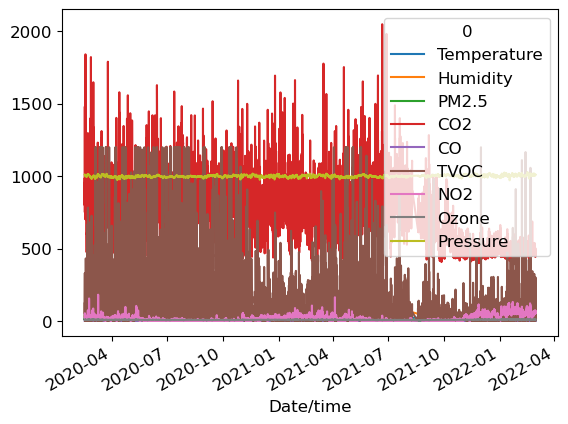

In [47]:
udf[interior_cols].plot.line()
#udf[interior_cols].plot.scatter(x='Pressure', y='Date/time')

<AxesSubplot: xlabel='Date/time'>

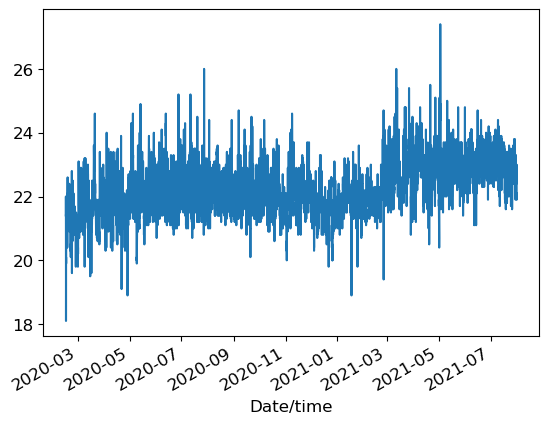

In [48]:
testdf = udf[(udf.datetime <= '2021-08-01')].copy()
#testdf = udf[(udf.datetime >= '2021-09-01')].copy()
testdf['Temperature'].plot.line()


<AxesSubplot: xlabel='Date/time'>

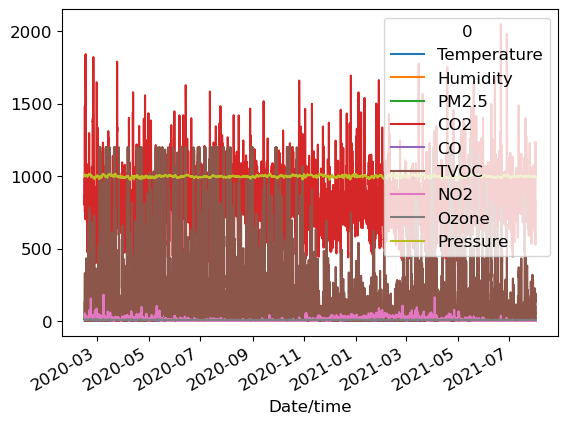

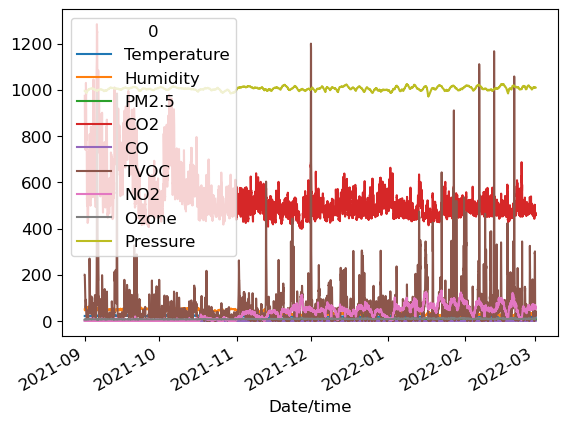

In [49]:
# separate 3 sensor locations 
#df1 = udf.loc[:, (udf['datetime'] >= '2021-04-01') & (udf['datetime'] < '2021-08-01')]
#df2 = udf.loc[:, (udf['datetime'] >= '2021-09-01') & (udf['datetime'] < '2021-11-23')]
#df3 = udf.loc[:, (udf['datetime'] >= '2021-11-24')]

#cond1 = (udf.datetime>='2021-04-01') & (udf.datetime < '2021-08-01')
#df1 = udf[(udf.datetime>='2021-04-01') & (udf.datetime < '2021-08-01')].copy()
#df2 = udf[(udf['datetime'] >= '2021-09-01') & (udf['datetime'] < '2021-11-23')].copy()
#df3 = udf[(udf['datetime'] >= '2021-11-24')].copy()

df1 = udf[(udf.datetime <= '2021-08-01')].copy()
df2 = udf[(udf.datetime >= '2021-09-01')].copy()

#idx1 = np.where( cond1)[0]

#df1 = udf[idx1].copy()
#df1.describe()
#splits = (list(train_idx), list(valid_idx))

df1[interior_cols].plot.line()
df2[interior_cols].plot.line()
#df3[interior_cols].plot.line()

In [50]:
df1.describe()

,Temperature,Humidity,PM2.5,CO2,CO,TVOC,NO2,Ozone,Pressure,Temperature_prev,Humidity_prev,PM2.5_prev,CO2_prev,CO_prev,TVOC_prev,NO2_prev,Ozone_prev,Pressure_prev
count,36483.000000,36483.000000,36483.000000,36483.000000,36483.000000,36483.000000,36483.000000,36483.000000,36483.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000
mean,22.239824,42.507510,2.000751,831.441082,0.019642,186.306389,13.089793,7.547713,999.096291,22.239828,42.507289,2.000778,831.436599,0.019643,186.307796,13.090132,7.547722,999.096385
std,0.763707,11.319164,2.955561,167.629187,0.211393,253.768245,13.799693,0.519835,6.590872,0.763717,11.319240,2.955597,167.629297,0.211395,253.771581,13.799730,0.519838,6.590938
min,18.100000,10.700000,1.000000,400.000000,0.000000,0.000000,0.000000,3.900000,975.100000,18.100000,10.700000,1.000000,400.000000,0.000000,0.000000,0.000000,3.900000,975.100000
25%,21.700000,32.200000,1.000000,732.000000,0.000000,35.000000,0.800000,7.200000,994.800000,21.700000,32.200000,1.000000,732.000000,0.000000,35.000000,0.800000,7.200000,994.800000
50%,22.200000,43.300000,1.000000,835.000000,0.000000,92.000000,8.200000,7.500000,998.900000,22.200000,43.300000,1.000000,835.000000,0.000000,92.000000,8.200000,7.500000,998.900000
75%,22.700000,52.500000,1.000000,933.000000,0.000000,220.000000,23.500000,7.900000,1003.600000,22.700000,52.500000,1.000000,933.000000,0.000000,220.000000,23.500000,7.900000,1003.600000
max,27.400000,82.000000,123.200000,2050.000000,7.900000,1200.000000,181.400000,13.600000,1018.000000,27.400000,82.000000,123.200000,2050.000000,7.900000,1200.000000,181.400000,13.600000,1018.000000


In [51]:
from fastai.tabular.core import add_datepart
#add_datepart(df1, 'datetime', drop=False)
df1.reset_index(drop=True, inplace=True)
df1

,Temperature,Humidity,PM2.5,CO2,CO,TVOC,NO2,Ozone,Pressure,datetime,Temperature_prev,Humidity_prev,PM2.5_prev,CO2_prev,CO_prev,TVOC_prev,NO2_prev,Ozone_prev,Pressure_prev
0,21.4,33.9,7.9,807,0.0,53,21.9,7.9,1011.0,2020-02-15 16:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21.4,33.9,7.9,808,0.0,55,22.1,7.9,1011.0,2020-02-15 16:20:00,21.4,33.9,7.9,807.0,0.0,53.0,21.9,7.9,1011.0
2,21.4,33.8,7.3,808,0.0,55,21.1,7.8,1011.1,2020-02-15 16:23:00,21.4,33.9,7.9,808.0,0.0,55.0,22.1,7.9,1011.0
3,21.4,33.9,7.6,812,0.0,55,22.4,7.9,1011.1,2020-02-15 16:24:00,21.4,33.8,7.3,808.0,0.0,55.0,21.1,7.8,1011.1
4,21.4,33.9,7.4,813,0.0,54,21.5,7.9,1011.1,2020-02-15 16:25:00,21.4,33.9,7.6,812.0,0.0,55.0,22.4,7.9,1011.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36478,22.2,50.2,1.0,1068,0.0,158,0.0,7.2,995.8,2021-07-31 22:08:00,22.2,50.2,2.0,1067.0,0.0,161.0,0.4,7.2,995.8
36479,22.2,50.2,1.0,1071,0.0,158,0.4,7.2,995.8,2021-07-31 22:09:00,22.2,50.2,1.0,1068.0,0.0,158.0,0.0,7.2,995.8
36480,22.3,47.5,1.0,997,0.0,147,0.6,7.2,995.7,2021-07-31 23:06:00,22.2,50.2,1.0,1071.0,0.0,158.0,0.4,7.2,995.8
36481,22.3,50.7,1.0,998,0.0,142,0.6,7.2,995.7,2021-07-31 23:07:00,22.3,47.5,1.0,997.0,0.0,147.0,0.6,7.2,995.7


In [133]:
weatherDataFile = "WU_20200201-20210801.txt"
wdf = pd.read_csv('uHoo/'+weatherDataFile, delimiter='\t')
exterior_cols = [c for c in wdf.columns if c!='Date']

# Convert first column to date type
wdf['Date'] = pd.to_datetime(wdf['Date'], format="%m/%d/%y")

# Set date/time index
wdf = wdf.set_index('Date')
wdf['date'] = wdf.index

# Add shifts
for col in exterior_cols:
    wdf["%s_prev"%col] = wdf[col].shift(1)

wdf.head(10)

,TempF_Max,TempF_Avg,TempF_Min,DewPointF_Max,DewPointF_Avg,DewPointF_Min,Humidity_Max,Humidity_Avg,Humidity_Min,WindSpeedMPH_Max,WindSpeedMPH_Avg,WindSpeedMPH_Min,PressureIN_Max,PressureIN_Avg,PressureIN_Min,PrecipitationIN_Total,date,TempF_Max_prev,TempF_Avg_prev,TempF_Min_prev,DewPointF_Max_prev,DewPointF_Avg_prev,DewPointF_Min_prev,Humidity_Max_prev,Humidity_Avg_prev,Humidity_Min_prev,WindSpeedMPH_Max_prev,WindSpeedMPH_Avg_prev,WindSpeedMPH_Min_prev,PressureIN_Max_prev,PressureIN_Avg_prev,PressureIN_Min_prev,PrecipitationIN_Total_prev
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-02-01,49,37.8,26,38,32.5,23,93,82.2,59,13,3.2,0,29.8,29.6,29.4,0.00,2020-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,58,41.9,30,35,30.6,28,100,68.2,37,18,6.8,0,29.4,29.3,29.1,0.10,2020-02-02,49.0,37.8,26.0,38.0,32.5,23.0,93.0,82.2,59.0,13.0,3.2,0.0,29.8,29.6,29.4,0.00
2020-02-03,67,57.6,43,37,34.4,31,62,42.5,29,20,9.3,3,29.6,29.5,29.3,0.00,2020-02-03,58.0,41.9,30.0,35.0,30.6,28.0,100.0,68.2,37.0,18.0,6.8,0.0,29.4,29.3,29.1,0.10
2020-02-04,66,59.3,54,49,43.6,37,75,56.6,47,10,5.0,0,29.5,29.5,29.4,0.00,2020-02-04,67.0,57.6,43.0,37.0,34.4,31.0,62.0,42.5,29.0,20.0,9.3,3.0,29.6,29.5,29.3,0.00
2020-02-05,58,41.8,37,49,35.8,30,96,79.7,68,21,9.3,0,29.8,29.6,29.4,0.01,2020-02-05,66.0,59.3,54.0,49.0,43.6,37.0,75.0,56.6,47.0,10.0,5.0,0.0,29.5,29.5,29.4,0.00
2020-02-06,47,41.6,37,46,39.5,35,100,92.3,89,16,5.4,0,29.5,29.2,29.0,0.11,2020-02-06,58.0,41.8,37.0,49.0,35.8,30.0,96.0,79.7,68.0,21.0,9.3,0.0,29.8,29.6,29.4,0.01
2020-02-07,59,47.8,34,55,40.1,18,97,76.8,43,29,14.8,0,29.6,28.9,28.6,0.69,2020-02-07,47.0,41.6,37.0,46.0,39.5,35.0,100.0,92.3,89.0,16.0,5.4,0.0,29.5,29.2,29.0,0.11
2020-02-08,44,35.6,29,23,18.9,16,69,51.7,38,15,7.0,3,30.0,29.9,29.6,0.27,2020-02-08,59.0,47.8,34.0,55.0,40.1,18.0,97.0,76.8,43.0,29.0,14.8,0.0,29.6,28.9,28.6,0.69
2020-02-09,49,38.4,24,29,23.6,20,88,58.2,37,13,5.1,0,30.2,30.1,30.0,0.00,2020-02-09,44.0,35.6,29.0,23.0,18.9,16.0,69.0,51.7,38.0,15.0,7.0,3.0,30.0,29.9,29.6,0.27


In [80]:
# add date (without time) column for join
df1['date'] = pd.to_datetime(df1['datetime'].dt.date)

# Create merged data set
mdf = df1.merge(wdf, on=["date"], how="left")

# Add derivatives
#for col in interior_cols:
#    mdf["%s_diff"%col] = mdf[col].diff(periods=2)

#for col in exterior_cols:
#    mdf["%s_diff"%col] = mdf[col].diff(periods=24)

# Add rain prediction column
#mdf['Rain'] = np.where(mdf['PrecipitationIN_Total']>0.0, True, False)

# Remove initial rows with NaN for prev values
mdf = mdf[1:]

# Show
#mdf.info()
mdf

,Temperature,Humidity,PM2.5,CO2,CO,TVOC,NO2,Ozone,Pressure,datetime,Temperature_prev,Humidity_prev,PM2.5_prev,CO2_prev,CO_prev,TVOC_prev,NO2_prev,Ozone_prev,Pressure_prev,date,TempF_Max,TempF_Avg,TempF_Min,DewPointF_Max,DewPointF_Avg,DewPointF_Min,Humidity_Max,Humidity_Avg,Humidity_Min,WindSpeedMPH_Max,WindSpeedMPH_Avg,WindSpeedMPH_Min,PressureIN_Max,PressureIN_Avg,PressureIN_Min,PrecipitationIN_Total,TempF_Max_prev,TempF_Avg_prev,TempF_Min_prev,DewPointF_Max_prev,DewPointF_Avg_prev,DewPointF_Min_prev,Humidity_Max_prev,Humidity_Avg_prev,Humidity_Min_prev,WindSpeedMPH_Max_prev,WindSpeedMPH_Avg_prev,WindSpeedMPH_Min_prev,PressureIN_Max_prev,PressureIN_Avg_prev,PressureIN_Min_prev,PrecipitationIN_Total_prev
1,21.4,33.9,7.9,808,0.0,55,22.1,7.9,1011.0,2020-02-15 16:20:00,21.4,33.9,7.9,807.0,0.0,53.0,21.9,7.9,1011.0,2020-02-15,36,27.2,16,18,12.3,7,77,55.2,39,12,5.5,0,30.3,30.2,30.0,0.0,40.0,33.4,23.0,26.0,15.3,6.0,65.0,48.0,37.0,21.0,12.8,3.0,30.3,30.0,29.7,0.04
2,21.4,33.8,7.3,808,0.0,55,21.1,7.8,1011.1,2020-02-15 16:23:00,21.4,33.9,7.9,808.0,0.0,55.0,22.1,7.9,1011.0,2020-02-15,36,27.2,16,18,12.3,7,77,55.2,39,12,5.5,0,30.3,30.2,30.0,0.0,40.0,33.4,23.0,26.0,15.3,6.0,65.0,48.0,37.0,21.0,12.8,3.0,30.3,30.0,29.7,0.04
3,21.4,33.9,7.6,812,0.0,55,22.4,7.9,1011.1,2020-02-15 16:24:00,21.4,33.8,7.3,808.0,0.0,55.0,21.1,7.8,1011.1,2020-02-15,36,27.2,16,18,12.3,7,77,55.2,39,12,5.5,0,30.3,30.2,30.0,0.0,40.0,33.4,23.0,26.0,15.3,6.0,65.0,48.0,37.0,21.0,12.8,3.0,30.3,30.0,29.7,0.04
4,21.4,33.9,7.4,813,0.0,54,21.5,7.9,1011.1,2020-02-15 16:25:00,21.4,33.9,7.6,812.0,0.0,55.0,22.4,7.9,1011.1,2020-02-15,36,27.2,16,18,12.3,7,77,55.2,39,12,5.5,0,30.3,30.2,30.0,0.0,40.0,33.4,23.0,26.0,15.3,6.0,65.0,48.0,37.0,21.0,12.8,3.0,30.3,30.0,29.7,0.04
5,21.4,34.1,10.9,814,0.0,53,22.4,7.9,1011.1,2020-02-15 16:26:00,21.4,33.9,7.4,813.0,0.0,54.0,21.5,7.9,1011.1,2020-02-15,36,27.2,16,18,12.3,7,77,55.2,39,12,5.5,0,30.3,30.2,30.0,0.0,40.0,33.4,23.0,26.0,15.3,6.0,65.0,48.0,37.0,21.0,12.8,3.0,30.3,30.0,29.7,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36478,22.2,50.2,1.0,1068,0.0,158,0.0,7.2,995.8,2021-07-31 22:08:00,22.2,50.2,2.0,1067.0,0.0,161.0,0.4,7.2,995.8,2021-07-31,83,74.0,67,62,57.0,53,68,55.9,42,8,5.5,0,29.7,29.6,29.6,0.0,90.0,81.5,72.0,71.0,61.9,53.0,93.0,54.8,29.0,16.0,8.7,0.0,29.6,29.5,29.4,0.00
36479,22.2,50.2,1.0,1071,0.0,158,0.4,7.2,995.8,2021-07-31 22:09:00,22.2,50.2,1.0,1068.0,0.0,158.0,0.0,7.2,995.8,2021-07-31,83,74.0,67,62,57.0,53,68,55.9,42,8,5.5,0,29.7,29.6,29.6,0.0,90.0,81.5,72.0,71.0,61.9,53.0,93.0,54.8,29.0,16.0,8.7,0.0,29.6,29.5,29.4,0.00
36480,22.3,47.5,1.0,997,0.0,147,0.6,7.2,995.7,2021-07-31 23:06:00,22.2,50.2,1.0,1071.0,0.0,158.0,0.4,7.2,995.8,2021-07-31,83,74.0,67,62,57.0,53,68,55.9,42,8,5.5,0,29.7,29.6,29.6,0.0,90.0,81.5,72.0,71.0,61.9,53.0,93.0,54.8,29.0,16.0,8.7,0.0,29.6,29.5,29.4,0.00
36481,22.3,50.7,1.0,998,0.0,142,0.6,7.2,995.7,2021-07-31 23:07:00,22.3,47.5,1.0,997.0,0.0,147.0,0.6,7.2,995.7,2021-07-31,83,74.0,67,62,57.0,53,68,55.9,42,8,5.5,0,29.7,29.6,29.6,0.0,90.0,81.5,72.0,71.0,61.9,53.0,93.0,54.8,29.0,16.0,8.7,0.0,29.6,29.5,29.4,0.00


In [81]:
from fastbook import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from dtreeviz.trees import *

In [82]:
from fastai.tabular.all import *
    
train_idx = np.where((mdf.date<'2021-02-01'))[0]
valid_idx = np.where((mdf.date>='2021-02-01') & (mdf.date<'2021-05-01'))[0]
test_idx = np.where((mdf.date>='2021-05-01'))[0]
splits = (list(train_idx), list(valid_idx))

def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

len(train_idx), len(valid_idx), len(test_idx)

(24271, 5979, 6232)

In [112]:
dep_var = 'PrecipitationIN_Total'

# Create final training data frame
tdf = mdf.copy()
# Drop useless columns
tdf = tdf.drop(['datetime','date',dep_var+"_prev"], axis=1)
# Fix for https://forums.fast.ai/t/tabular-learner-error-found-dtype-char-but-expected-float/77245/12
tdf = tdf.astype({dep_var: np.float16}) 

Predicting PrecipitationIN_Total
Decision Tree
Train RMSE: 0.2466
Valid RMSE: 0.4339


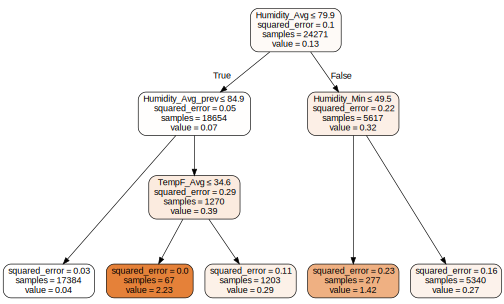

/Users/rokickik/opt/anaconda3/envs/course22/lib/python3.8/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


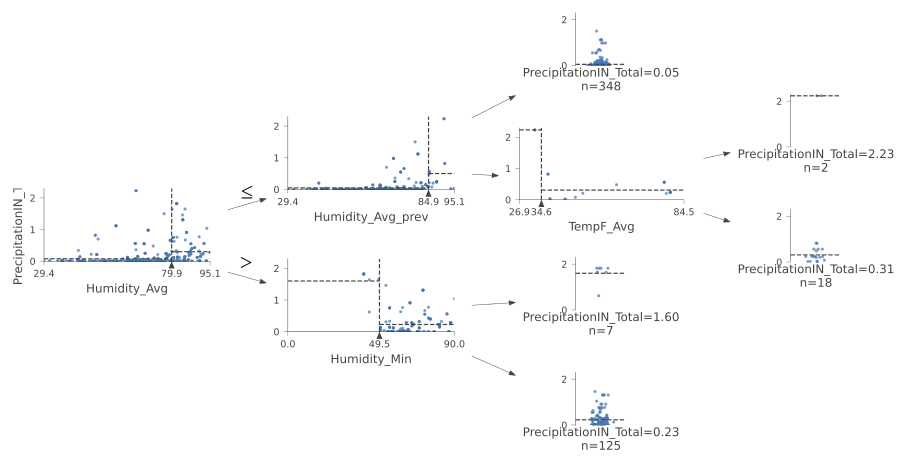

In [113]:
cont,cat = cont_cat_split(tdf, 1, dep_var=dep_var)
to = TabularPandas(tdf, [Categorify, FillMissing], cat, cont, y_names=dep_var, splits=splits)

xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = DecisionTreeRegressor(max_leaf_nodes=5)
m.fit(xs, y)

print("Predicting %s" % (dep_var))
print("Decision Tree")
print("Train RMSE: %2.4f" % m_rmse(m, xs, y))
print("Valid RMSE: %2.4f" % m_rmse(m, valid_xs, valid_y))
#print("Test RMSE: %2.4f" % m_rmse(m, valid_xs, valid_y))

g1 = draw_tree(m, xs, size=7, leaves_parallel=True, precision=2);
display(g1)

samp_idx = np.random.permutation(len(y))[:500]
g2 = dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var, fontname='DejaVu Sans', scale=1.6, label_fontsize=10, orientation='LR');
display(g2)

/Users/rokickik/opt/anaconda3/envs/course22/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1259: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


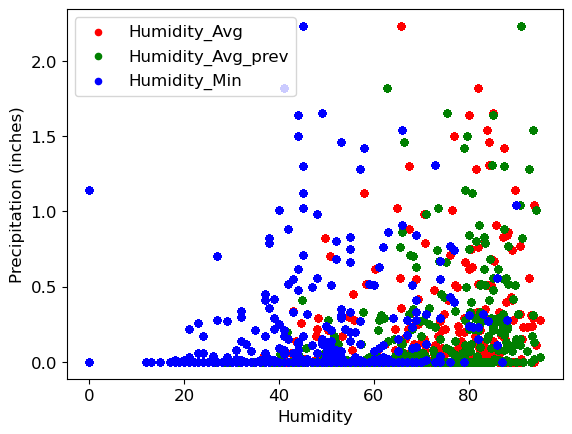

In [110]:
#mdf.plot.scatter(x='Pressure', y='PressureIN_Max')
#mdf.plot.scatter(x='TempF_Max', y=['Temperature'])
#mdf.plot.scatter(x='Ozone', y=['NO2'])
ax = tdf.plot.scatter(x='Humidity_Avg', y='PrecipitationIN_Total', color='r', label='Humidity_Avg')
tdf.plot.scatter(x='Humidity_Avg_prev', y='PrecipitationIN_Total', color='g', label='Humidity_Avg_prev', ax=ax)
tdf.plot.scatter(x='Humidity_Min', y='PrecipitationIN_Total', color='b', label='Humidity_Min', ax=ax)
ax.set_xlabel("Humidity")
ax.set_ylabel("Precipitation (inches)")
plt.show()


In [146]:
def rf(xs, y, n_estimators=40, max_samples=100_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

#m = rf(xs, y, n_estimators=10, max_samples=200);
m = rf(xs, y, n_estimators=200, max_samples=None, max_depth=8);

print("Random Forest")
print("Train RMSE: %2.4f" % m_rmse(m, xs, y))
print("Valid RMSE: %2.4f" % m_rmse(m, valid_xs, valid_y))
print("Valid OOB: %2.4f" % r_mse(m.oob_prediction_, y))

Random Forest
Train RMSE: 0.0009
Valid RMSE: 0.2708
Valid OOB: 0.0015


In [86]:
#preds = np.stack([t.predict(valid_xs) for t in m.estimators_])
#vdf = to.valid.copy()
#vdf['pred_mean'] = pd.Series(preds.mean())
#vdf['pred_std'] = pd.Series(preds.std(0))
#pd.DataFrame(data=vdf.xs, columns=vdf.x_names+['pred_mean','pred_std'])


<AxesSubplot: ylabel='cols'>

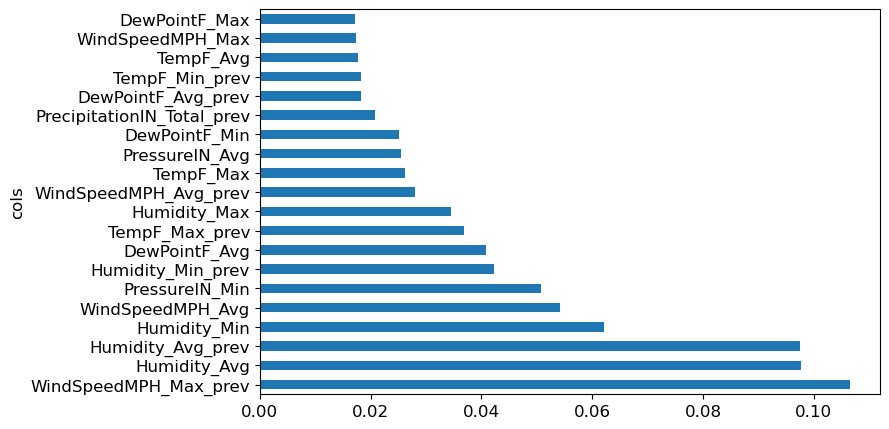

In [108]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(8,5), legend=False)
plot_fi(fi[:20])


In [88]:
# random forest parameter search
i_range = range(0,5) # number of trials per parameter set
s_range = range(200,2000,200) # max_samples
n_range = range(1,50,2) # n_estimators

import numpy as np
param_arr = np.zeros((2, len(i_range), len(s_range), len(n_range)))
param_arr.shape

(2, 5, 9, 25)

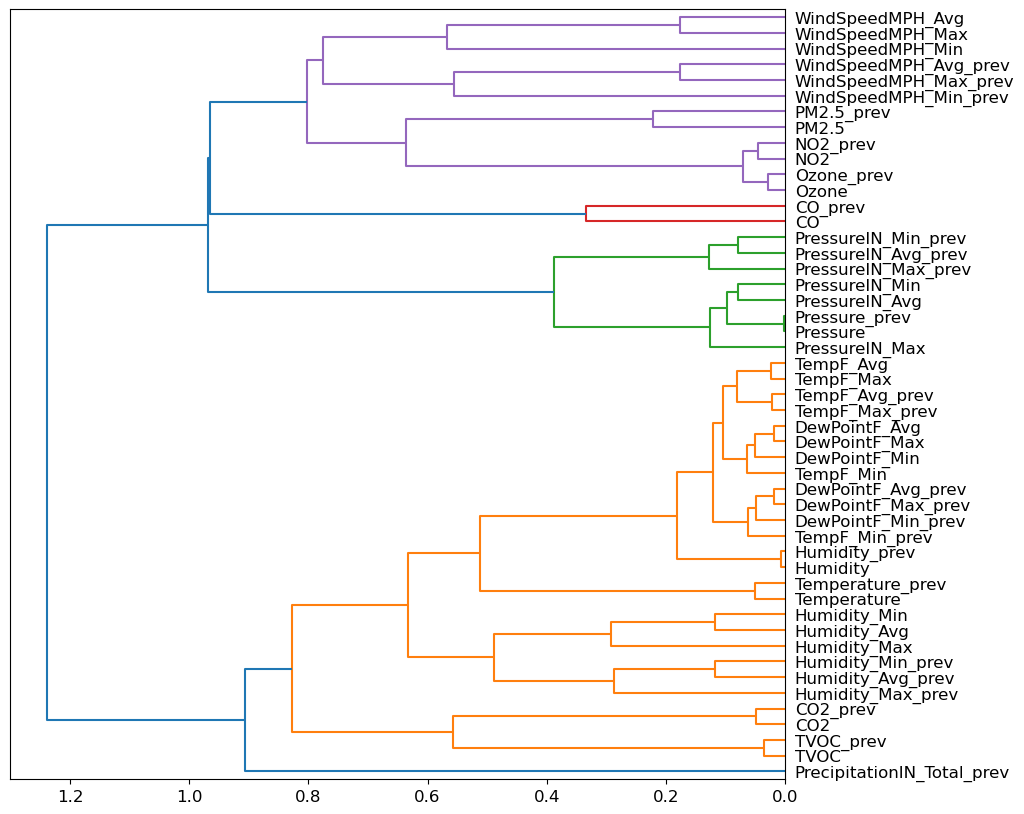

In [89]:
# rank correlation of column values
cluster_columns(xs, figsize=(10,10))

In [90]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#TODO: try max_depth

for i in i_range:
    j = 0
    for s in s_range:
        k = 0
        for n in n_range:
            m = rf(xs, y, n_estimators=n, max_samples=s);
            param_arr[0,i,j,k] = m_rmse(m, xs, y)
            param_arr[1,i,j,k] = m_rmse(m, valid_xs, valid_y)
            k += 1
        j += 1

warnings.filterwarnings("default", category=UserWarning)

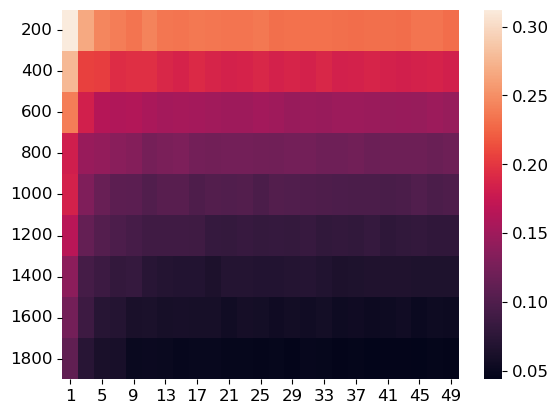

In [91]:
# plot average RMSE for training set
import seaborn as sns
%matplotlib inline

params = pd.DataFrame(param_arr[0].mean(axis=0), index=s_range, columns=n_range)
sns.heatmap(params, annot=False);

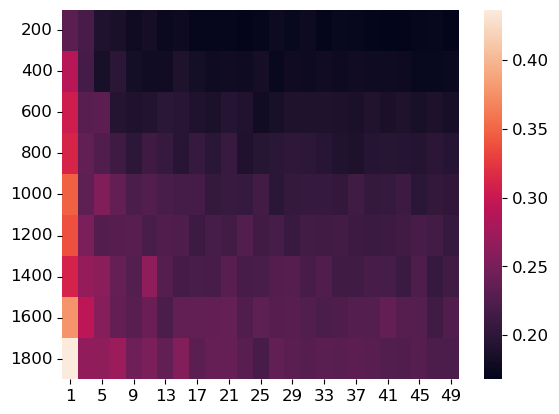

In [92]:
# plot average RMSE for validation set
params = pd.DataFrame(param_arr[1].mean(axis=0), index=s_range, columns=n_range)
sns.heatmap(params, annot=False);

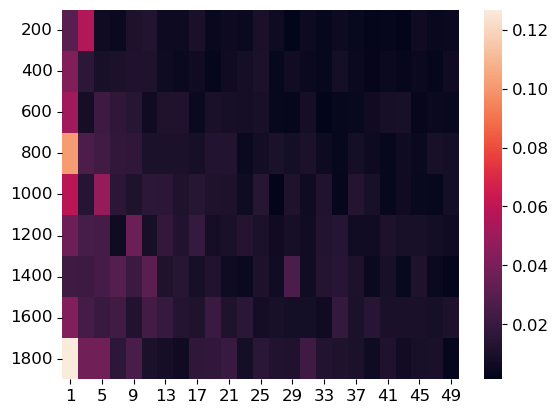

In [93]:
# plot stddev of RMSE for validation set
params = pd.DataFrame(param_arr[1].std(axis=0), index=s_range, columns=n_range)
sns.heatmap(params, annot=False);

In [114]:
tdf.describe()

,Temperature,Humidity,PM2.5,CO2,CO,TVOC,NO2,Ozone,Pressure,Temperature_prev,Humidity_prev,PM2.5_prev,CO2_prev,CO_prev,TVOC_prev,NO2_prev,Ozone_prev,Pressure_prev,TempF_Max,TempF_Avg,TempF_Min,DewPointF_Max,DewPointF_Avg,DewPointF_Min,Humidity_Max,Humidity_Avg,Humidity_Min,WindSpeedMPH_Max,WindSpeedMPH_Avg,WindSpeedMPH_Min,PressureIN_Max,PressureIN_Avg,PressureIN_Min,PrecipitationIN_Total,TempF_Max_prev,TempF_Avg_prev,TempF_Min_prev,DewPointF_Max_prev,DewPointF_Avg_prev,DewPointF_Min_prev,Humidity_Max_prev,Humidity_Avg_prev,Humidity_Min_prev,WindSpeedMPH_Max_prev,WindSpeedMPH_Avg_prev,WindSpeedMPH_Min_prev,PressureIN_Max_prev,PressureIN_Avg_prev,PressureIN_Min_prev
count,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.00000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.00000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000,36482.000000
mean,22.239847,42.507746,2.000589,831.441752,0.019643,186.310043,13.089551,7.547703,999.095965,22.239828,42.507289,2.000778,831.436599,0.019643,186.307796,13.090132,7.547722,999.096385,67.955348,58.194236,48.290499,50.813716,45.55145,39.503152,87.015734,66.259681,44.395921,14.668604,7.043649,0.862836,29.806532,29.706346,29.462244,0.117676,67.784771,58.04486,48.143934,50.665835,45.384836,39.307056,86.986815,66.202560,44.353188,14.734307,7.085609,0.884135,29.809501,29.708451,29.463656
std,0.763705,11.319230,2.955440,167.631435,0.211395,253.770763,13.799806,0.519838,6.590668,0.763717,11.319240,2.955597,167.629297,0.211395,253.771581,13.799730,0.519838,6.590938,16.995029,15.888499,16.404522,16.992424,17.84167,18.847525,11.777492,14.643396,15.372194,5.642253,3.300381,2.142914,0.186372,0.228508,2.196733,0.290527,17.148637,16.00954,16.520570,17.138383,17.995745,19.001553,11.813167,14.677131,15.366764,5.647450,3.326468,2.163953,0.190155,0.230496,2.196880
min,18.100000,10.700000,1.000000,400.000000,0.000000,0.000000,0.000000,3.900000,975.100000,18.100000,10.700000,1.000000,400.000000,0.000000,0.000000,0.000000,3.900000,975.100000,30.000000,26.900000,0.000000,9.000000,6.60000,0.000000,38.000000,26.500000,0.000000,5.000000,1.000000,0.000000,29.300000,27.600000,0.000000,0.000000,30.000000,26.90000,0.000000,9.000000,6.600000,0.000000,38.000000,26.500000,0.000000,5.000000,1.000000,0.000000,29.300000,27.600000,0.000000
25%,21.700000,32.200000,1.000000,732.000000,0.000000,35.000000,0.800000,7.200000,994.800000,21.700000,32.200000,1.000000,732.000000,0.000000,35.000000,0.800000,7.200000,994.800000,54.000000,44.800000,35.000000,37.000000,30.00000,23.000000,82.000000,54.400000,34.000000,10.000000,4.900000,0.000000,29.700000,29.600000,29.500000,0.000000,54.000000,44.70000,35.000000,37.000000,29.600000,23.000000,82.000000,54.225000,34.000000,10.000000,4.900000,0.000000,29.700000,29.600000,29.500000
50%,22.200000,43.300000,1.000000,835.500000,0.000000,92.000000,8.200000,7.500000,998.900000,22.200000,43.300000,1.000000,835.000000,0.000000,92.000000,8.200000,7.500000,998.900000,70.000000,57.800000,47.000000,52.000000,46.00000,39.000000,91.000000,67.000000,43.000000,14.000000,6.300000,0.000000,29.800000,29.700000,29.600000,0.000000,69.000000,57.80000,47.000000,52.000000,45.700000,38.000000,91.000000,67.000000,43.000000,14.000000,6.300000,0.000000,29.800000,29.700000,29.600000
75%,22.700000,52.500000,1.000000,933.000000,0.000000,220.000000,23.500000,7.900000,1003.600000,22.700000,52.500000,1.000000,933.000000,0.000000,220.000000,23.500000,7.900000,1003.600000,83.000000,73.000000,64.000000,66.000000,62.10000,57.000000,96.000000,78.500000,54.000000,17.000000,8.80000

In [115]:
to = TabularPandas(tdf, [Categorify, FillMissing], cat, cont, y_names=dep_var, splits=splits)
dls = to.dataloaders(bs=32)
dls.show_batch()

,Temperature,Humidity,PM2.5,CO2,CO,TVOC,NO2,Ozone,Pressure,Temperature_prev,Humidity_prev,PM2.5_prev,CO2_prev,CO_prev,TVOC_prev,NO2_prev,Ozone_prev,Pressure_prev,TempF_Max,TempF_Avg,TempF_Min,DewPointF_Max,DewPointF_Avg,DewPointF_Min,Humidity_Max,Humidity_Avg,Humidity_Min,WindSpeedMPH_Max,WindSpeedMPH_Avg,WindSpeedMPH_Min,PressureIN_Max,PressureIN_Avg,PressureIN_Min,TempF_Max_prev,TempF_Avg_prev,TempF_Min_prev,DewPointF_Max_prev,DewPointF_Avg_prev,DewPointF_Min_prev,Humidity_Max_prev,Humidity_Avg_prev,Humidity_Min_prev,WindSpeedMPH_Max_prev,WindSpeedMPH_Avg_prev,WindSpeedMPH_Min_prev,PressureIN_Max_prev,PressureIN_Avg_prev,PressureIN_Min_prev,PrecipitationIN_Total
0,21.600000,28.900000,7.6,1024.0,0.0,286.0,30.200001,8.1,1000.799988,21.600000,29.000000,7.6,1015.0,0.0,280.0,30.700001,8.1,1000.799988,51.0,37.799999,23.0,16.0,13.500000,11.0,68.0,39.599998,22.0,10.0,6.2,0.0,29.900000,29.900000,29.799999,36.0,31.900000,27.0,16.0,11.800000,9.0,63.0,44.099998,34.0,25.0,15.1,3.0,29.799999,29.700001,29.600000,0.000000
1,22.600000,37.700001,1.0,667.0,0.0,275.0,18.600000,7.9,999.900024,22.900000,38.799999,1.0,666.0,0.0,144.0,17.000000,7.9,999.700012,82.0,72.800003,65.0,58.0,54.500000,49.0,75.0,53.599998,35.0,13.0,6.8,0.0,29.799999,29.700001,29.600000,86.0,74.099998,62.0,62.0,57.799999,53.0,90.0,60.599998,34.0,20.0,11.4,7.0,29.700001,29.600000,29.500000,0.000000
2,22.799999,52.000000,1.0,1079.0,0.0,526.0,0.400000,7.0,998.099976,22.799999,52.000000,1.0,1074.0,0.0,526.0,0.800000,7.0,998.099976,91.0,73.800003,0.0,73.0,65.699997,0.0,100.0,72.500000,0.0,15.0,5.9,0.0,29.700001,29.600000,29.500000,88.0,78.599998,71.0,74.0,71.599998,69.0,97.0,80.099998,61.0,9.0,3.6,0.0,29.799999,29.700001,29.600000,0.000000
3,23.000000,51.400002,7.8,605.0,0.0,0.0,4.600000,7.5,996.799988,22.900000,51.400002,7.3,632.0,0.0,0.0,3.700000,7.5,997.000000,79.0,67.800003,55.0,60.0,55.900002,49.0,96.0,68.099998,44.0,21.0,9.4,0.0,29.799999,29.600000,29.500000,73.0,57.099998,46.0,58.0,51.200001,44.0,97.0,81.699997,55.0,10.0,5.4,0.0,29.900000,29.799999,29.799999,0.040009
4,23.100000,55.099998,5.0,812.0,0.0,456.0,0.300000,6.9,990.900024,22.400000,55.000000,1.0,703.0,0.0,260.0,0.700000,7.1,990.299988,88.0,79.199997,71.0,72.0,67.199997,60.0,93.0,69.400002,40.0,20.0,7.2,0.0,29.500000,29.400000,29.400000,90.0,80.599998,73.0,73.0,70.000000,68.0,91.0,71.599998,50.0,12.0,7.0,0.0,29.600000,29.500000,29.400000,0.250000
5,22.400000,60.799999,1.0,915.0,0.0,10.0,0.800000,7.0,1000.599976,22.299999,60.900002,1.0,914.0,0.0,10.0,0.500000,7.0,1000.700012,92.0,78.599998,71.0,73.0,71.000000,67.0,97.0,80.099998,44.0,14.0,4.6,0.0,29.799999,29.700001,29.700001,94.0,77.300003,71.0,75.0,71.800003,69.0,97.0,85.099998,52.0,25.0,5.6,0.0,29.799999,29.700001,29.600000,1.639648
6,22.400000,58.000000,1.0,1000.0,0.0,90.0,0.600000,6.9,996.000000,22.400000,57.700001,1.0,1013.0,0.0,132.0,1.000000,6.8,996.000000,75.0,63.099998,56.0,63.0,55.400002,42.0,96.0,77.199997,57.0,15.0,7.5,0.0,29.799999,29.600000,29.600000,77.0,66.699997,58.0,64.0,60.299999,57.0,100.0,81.699997,54.0,12.0,5.6,0.0,29.900000,29.799999,29.700001,0.000000
7,20.900000,30.600000,1.0,806.0,0.0,46.0,29.100000,8.1,1010.799988,20.900000,30.799999,1.0,806.0,0.0,63.0,29.400000,8.2,1011.099976,36.0,30.400000,24.0,29.0,25.100000,21.0,92.0,80.800003,70.0,7.0,2.6,0.0,30.100000,30.000000,29.900000,37.0,33.299999,27.0,31.0,27.100000,23.0,89.0,78.400002,66.0,8.0,4.3,0.0,30.100000,30.000000,29.799999,0.000000
8,22.799999,51.900002,1.0,775.0,0.0,244.0,0.900000,7.0,983.400024,23.000000,56.099998,1.0,790.0,0.0,254.0,0.700000,6.8,982.799988,86.0,75.300003,72.0,75.0,71.000000,61.0,97.0,87.500000,58.0,10.0,6.0,0.0,29.500000,29.400000,29.200001,91.0,77.699997,72.0,74.0,70.099998,65.0,97.0,79.000000,53.0,21.0,6.6,0.0,29.600000,29.500000,29.500000,1.419922
9,22.600000,63.200001,1.0,1169.0,0.0,80.0,0.800000,7.4,995.400024,22.700001,63.200001,1.0,1172.0,0.0,79.0,0.900000,7.5,995.400024,70.0,68.099998,64.0,68.0,66.199997,60.0,100.0,93.500000,87.0,14.0,7.2,0.0,29.700001,29

In [120]:
to = TabularPandas(tdf, [Categorify, FillMissing, Normalize], cat, cont, y_names=dep_var, splits=splits)
dls = to.dataloaders(bs=32)
dls.show_batch()

,Temperature,Humidity,PM2.5,CO2,CO,TVOC,NO2,Ozone,Pressure,Temperature_prev,Humidity_prev,PM2.5_prev,CO2_prev,CO_prev,TVOC_prev,NO2_prev,Ozone_prev,Pressure_prev,TempF_Max,TempF_Avg,TempF_Min,DewPointF_Max,DewPointF_Avg,DewPointF_Min,Humidity_Max,Humidity_Avg,Humidity_Min,WindSpeedMPH_Max,WindSpeedMPH_Avg,WindSpeedMPH_Min,PressureIN_Max,PressureIN_Avg,PressureIN_Min,TempF_Max_prev,TempF_Avg_prev,TempF_Min_prev,DewPointF_Max_prev,DewPointF_Avg_prev,DewPointF_Min_prev,Humidity_Max_prev,Humidity_Avg_prev,Humidity_Min_prev,WindSpeedMPH_Max_prev,WindSpeedMPH_Avg_prev,WindSpeedMPH_Min_prev,PressureIN_Max_prev,PressureIN_Avg_prev,PressureIN_Min_prev,PrecipitationIN_Total
0,21.799999,27.899999,1.0,841.000000,2.000000e-01,110.999998,37.000001,8.4,1006.099975,21.700001,28.000000,1.0,900.000000,5.590642e-10,142.000001,32.799999,8.2,1005.900025,41.000000,30.600001,19.000001,30.000001,20.600000,16.000000,89.000000,68.300003,45.000000,10.0,4.4,9.219079e-09,30.000000,29.900000,29.799999,35.000001,27.000000,20.999999,16.000001,10.900000,8.000000,71.000000,52.000001,37.000000,13.0,6.8,1.101332e-08,29.799999,29.700001,29.600000,0.000000
1,21.799999,33.500000,8.0,1006.000005,1.578920e-10,123.999999,23.000000,8.0,1005.599976,21.900000,33.099999,7.4,1006.999998,5.590642e-10,123.999998,23.399999,8.0,1005.700012,53.000000,44.099998,30.000000,27.999999,24.899999,20.000001,79.000000,49.000000,30.000000,8.0,5.6,9.219079e-09,29.900000,29.900000,29.799999,53.000000,38.700000,30.000000,29.000000,22.500001,15.999999,73.000000,53.599999,34.000000,10.0,4.3,1.101332e-08,29.900000,29.799999,29.700001,0.000000
2,22.299999,59.599998,1.0,858.000000,1.578920e-10,62.000006,0.300000,7.0,994.400024,22.299999,59.500000,1.0,859.000001,5.590642e-10,61.999993,0.700000,7.0,994.500000,84.000001,73.000000,63.000000,68.999999,66.000001,61.000000,100.000000,80.099999,56.000000,9.0,4.4,9.219079e-09,29.600000,29.600000,29.500000,76.000000,69.400002,65.000000,66.000000,64.800003,63.000000,97.000000,85.800003,66.000000,13.0,6.3,1.101332e-08,29.600000,29.600000,29.600000,0.010002
3,21.100000,31.200001,4.0,731.000002,1.578920e-10,128.000001,33.299999,8.4,998.799988,20.900000,30.700001,1.0,786.999999,5.590642e-10,177.999998,33.400001,8.4,997.900024,63.000000,49.700001,35.000000,35.000000,26.499999,17.999999,86.000000,43.599998,26.999999,18.0,8.7,9.219079e-09,30.000000,29.799999,29.700001,48.000000,42.200001,37.000000,24.000001,20.500001,15.999999,54.999999,43.000000,32.000000,29.0,16.4,3.000000e+00,29.799999,29.700001,29.600000,0.000000
4,22.000000,54.900002,2.0,825.000000,1.578920e-10,99.999999,0.100000,7.0,993.799988,22.000000,55.000000,1.0,825.000001,5.590642e-10,101.000000,0.200000,7.1,993.900024,83.000000,66.800003,51.000000,56.000000,52.700001,49.000000,100.000000,64.800003,37.000000,15.0,6.8,9.219079e-09,29.600000,29.500000,29.400000,72.000000,54.900002,40.000000,52.000000,46.099998,39.000000,97.000000,75.500000,44.000000,9.0,3.5,1.101332e-08,29.900000,29.799999,29.600000,0.000000
5,21.700001,58.000001,1.0,869.000001,1.578920e-10,289.000004,0.500000,7.3,998.900024,21.500000,58.900001,1.0,908.000002,5.590642e-10,264.000002,0.700000,7.3,999.000000,62.000000,51.200001,45.000000,43.000000,39.700001,35.000000,83.000000,66.500000,42.000000,14.0,4.9,9.219079e-09,29.799999,29.700001,29.600000,68.000000,57.400002,49.000000,68.000001,52.400002,39.000000,100.000000,83.800003,66.000000,15.0,9.1,1.101332e-08,29.700001,29.600000,29.500000,0.150024
6,21.900000,25.200001,1.0,460.999992,1.578920e-10,23.000004,42.900003,8.5,1000.099976,21.700001,25.500000,1.0,461.999992,5.590642e-10,20.999992,44.200000,8.6,1000.000000,48.000001,42.200001,37.000000,24.000000,20.500000,16.000000,55.000001,43.000001,32.000000,29.0,16.4,3.000000e+00,29.799999,29.700001,29.600000,57.000000,49.000000,39.000000,52.000000,41.200001,18.999999,96.000000,77.099998,37.000000,24.0,10.9,1.101332e-08,30.000000,29.700001,29.400000,0.340088
7,22.799999,40.400002,7.3,713.999998,1.578920e-10,-0.000004,13.000000,7.7,1001.900024,2

epoch,train_loss,valid_loss,_rmse,mae,time
0,0.050603,0.081985,0.286330,0.215066,00:04
1,0.028236,0.052187,0.228445,0.154901,00:04
2,0.021000,0.050291,0.224256,0.144705,00:04
3,0.013923,0.052440,0.228997,0.144494,00:04
4,0.012240,0.058120,0.241082,0.143157,00:04
5,0.010090,0.053685,0.231701,0.139256,00:04
6,0.008947,0.050831,0.225458,0.133878,00:04
7,0.009164,0.053410,0.231106,0.136828,00:04
8,0.006594,0.050561,0.224857,0.134069,00:04
9,0.005612,0.048806,0.220921,0.130595,00:04


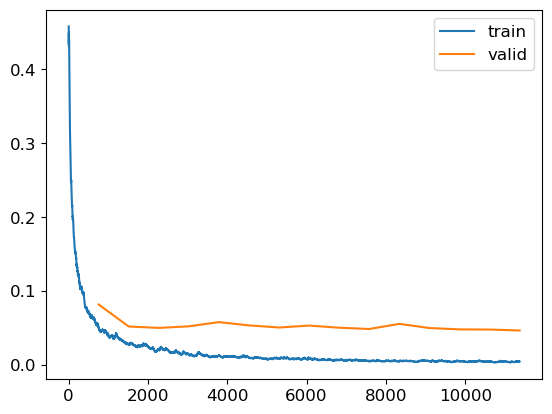

In [147]:
learn = tabular_learner(dls, loss_func=F.mse_loss, metrics=[rmse, mae], layers=[200,200])
learn.fit_one_cycle(15, 0.001)
learn.recorder.plot_loss()

In [132]:

def feature_importance(learner): 
    # based on: https://johnkeefe.net/detecting-feature-importance-in-fast-dot-ai-neural-networks
    # based on: https://medium.com/@mp.music93/neural-networks-feature-importance-with-fastai-5c393cf65815
    #data = learner.data.train_ds.x
    cat_names = learner.dls.cat_names
    cont_names = learner.dls.cont_name
    loss0=np.array([learner.loss_func(learner.pred_batch(batch=(x,y.to("cpu"))), y.to("cpu")) for x,y in iter(learner.dls.valid)]).mean()
    fi=dict()
    types=[cat_names, cont_names]
    for j, t in enumerate(types):
        for i, c in enumerate(t):
            loss=[]
            for x,y in iter(learner.valid_dl):
                col=x[j][:,i]    #x[0] da hier cat-vars
                idx = torch.randperm(col.nelement())
                x[j][:,i] = col.view(-1)[idx].view(col.size())
                y=y.to('cpu')
                loss.append(learner.loss_func(learner.pred_batch(batch=(x,y)), y))
            fi[c]=np.array(loss).mean()-loss0
    d = sorted(fi.items(), key=lambda kv: kv[1], reverse=True)
    return pd.DataFrame({'cols': [l for l, v in d], 'imp': np.log1p([v for l, v in d])})
    
# my model is called 'learn'
#features = feature_importance(learn)

# plot 'em!
#features.plot('cols', 'imp', 'barh', figsize=(12,15), legend=False)

In [96]:
preds,targs = learn.get_preds()
print("Valid RMSE: %2.2f" % r_mse(preds,targs))

Valid RMSE: 0.20


In [97]:
learn.show_results(max_n=20)

,Temperature,Humidity,PM2.5,CO2,CO,TVOC,NO2,Ozone,Pressure,Temperature_prev,Humidity_prev,PM2.5_prev,CO2_prev,CO_prev,TVOC_prev,NO2_prev,Ozone_prev,Pressure_prev,TempF_Max,TempF_Avg,TempF_Min,DewPointF_Max,DewPointF_Avg,DewPointF_Min,Humidity_Max,Humidity_Avg,Humidity_Min,WindSpeedMPH_Max,WindSpeedMPH_Avg,WindSpeedMPH_Min,PressureIN_Max,PressureIN_Avg,PressureIN_Min,TempF_Max_prev,TempF_Avg_prev,TempF_Min_prev,DewPointF_Max_prev,DewPointF_Avg_prev,DewPointF_Min_prev,Humidity_Max_prev,Humidity_Avg_prev,Humidity_Min_prev,WindSpeedMPH_Max_prev,WindSpeedMPH_Avg_prev,WindSpeedMPH_Min_prev,PressureIN_Max_prev,PressureIN_Avg_prev,PressureIN_Min_prev,PrecipitationIN_Total_prev,PrecipitationIN_Total,PrecipitationIN_Total_pred
0,-0.125578,-1.319932,-0.399670,0.565809,-0.09473,-0.416365,1.068634,0.731927,0.389580,0.023840,-1.329066,-0.399741,0.518563,-0.09473,-0.405629,1.076100,0.732049,0.389466,-2.002079,-1.572455,-1.055820,-1.054019,-0.917960,-0.899435,0.736031,1.339820,1.533026,-0.255452,0.038754,-0.391907,1.051288,0.903663,0.168255,-1.618066,-1.444026,-1.038392,-0.973687,-0.930300,-0.826884,1.085587,0.904551,0.606605,-0.442959,-0.980664,-0.402298,0.999608,0.880974,0.235066,-0.393078,0.33,0.181488
1,1.966306,-0.503133,-0.399670,0.004905,-0.09473,-0.745605,-0.396056,-0.606777,-0.008810,2.115761,-0.512246,-0.399741,0.004889,-0.09473,-0.749184,-0.439972,-0.798038,-0.024221,0.295100,0.346010,0.483094,-0.284447,-0.271071,-0.575955,-2.246028,-1.601940,-0.996307,-0.078393,0.406963,-0.391907,-0.569358,-0.045504,0.037694,0.957903,0.539579,-0.002623,0.020392,0.069496,0.132673,-0.386510,-1.014096,-1.125901,-0.266042,-0.889262,-0.402298,-0.571959,-0.529054,0.034598,-0.393078,0.00,-0.075641
2,0.023843,-1.728332,-0.399670,0.317831,-0.09473,-0.140806,1.266367,0.349441,1.952513,-0.275007,-1.701173,-0.399741,0.483137,-0.09473,-0.062075,1.317793,0.540789,1.906350,-0.672134,-1.265501,-1.794498,-1.705195,-1.682977,-1.654220,-0.228753,-1.439685,-1.861605,-0.786627,-1.035190,-0.391907,2.131724,1.852839,0.364099,-1.198722,-1.551762,-1.769523,-1.850816,-1.674592,-1.466589,-0.213322,-1.007068,-1.392441,-0.266042,-0.432255,-0.402298,1.523467,1.350987,0.235066,-0.393078,0.00,-0.010256
3,0.472103,-1.955221,-0.399670,-0.479243,-0.09473,1.451711,1.727744,0.731927,0.358942,0.472108,-1.964370,-0.399741,-0.520594,-0.09473,1.387295,1.640050,0.540789,0.374148,-0.188517,-0.389402,-0.809594,-1.468403,-1.502973,-1.708133,-2.684566,-2.688345,-1.928166,2.400429,2.493482,-0.391907,0.511069,0.429075,0.102975,-0.539754,-0.468067,-0.368189,-1.441489,-1.546840,-1.573207,-4.196645,-2.721903,-1.858885,0.087791,0.359892,-0.402298,0.999608,0.880974,0.235066,-0.393078,0.00,0.018909
4,1.368626,-0.076582,-0.399670,0.536288,-0.09473,-0.709818,-0.835463,-0.989265,-0.238653,1.069802,-0.094761,-0.399741,0.642554,-0.09473,-0.709818,-0.732933,-0.798038,-0.238733,0.113743,0.134978,0.359981,0.425926,0.538946,0.717963,0.823738,1.283383,1.266781,-0.786627,-0.452192,-0.391907,-0.569358,-0.520093,-0.092868,-0.419941,-0.068811,0.241087,0.312768,0.430533,0.345908,1.085587,1.530044,1.539493,-0.973709,-0.493189,-0.402298,-0.048110,-0.059042,0.101421,0.884568,0.07,0.176215
5,0.920366,-1.519594,-0.399670,0.252884,-0.09473,-0.480782,0.826960,-0.033047,-0.790271,0.920379,-1.519657,-0.399741,0.300104,-0.09473,-0.487939,0.702575,-0.224255,-0.790323,-0.853490,-0.894598,-0.994263,-1.290810,-1.199216,-1.384654,-2.246028,-1.411466,-0.796622,2.400429,2.248009,-0.391907,-0.569358,-0.520093,-0.027587,-0.479847,-0.930697,-1.343030,-1.383014,-1.319109,-1.146737,-0.819480,-1.365497,-1.592345,0.264708,-0.615058,-0.402298,-0.571959,-0.529054,-0.032226,-0.393078,0.00,-0.045136
6,-0.573838,-1.946145,-0.399670,-0.933871,-0.09473,-0.613193,1.932800,0.923172,0.312966,-0.573851,-1.937143,-0.399741,-0.933895,-0.09473,-0.620351,1.867095,0.923311,0.312856,-1.276654,-1.355029,-1.363602,-1.882788,-1.632351,-1.492480,-1.105829,-1.531394,-0.929745,1.161018,0.989961,-0.391907,0.511069,0.429075,0.168255,-1.498254,-1.501062,-1.403958,

In [98]:
learn.get_preds()[0]

#df['PrecipitationIN_Total_pred' < 0] = 0

tensor([[1.0644],
        [1.0711],
        [1.0676],
        [1.0667],
        [1.0689],
        [1.0682],
        [1.0661],
        ...,
        [0.2755],
        [0.2814],
        [0.2966],
        [0.2853],
        [0.2861],
        [0.2759],
        [0.2770]])